In [156]:
# Importando bibliotecas necessárias
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

In [157]:
# Carrega o dataset de treino
data_train = pd.read_csv('treino.csv')
data_train.head()

,Age,Gender,Income,Education_Level,Travel_Frequency,Preferred_Activities,Vacation_Budget,Location,Proximity_to_Mountains,Proximity_to_Beaches,Favorite_Season,Pets,Environmental_Concerns,Preference
0,50,female,38091,bachelor,3,hiking,1308,rural,41,85,spring,0,0,1
1,47,non-binary,50274,high school,6,hiking,2306,urban,239,218,summer,0,1,0
2,41,female,43443,doctorate,8,sunbathing,2351,rural,222,173,winter,1,0,0
3,69,non-binary,62584,doctorate,9,sunbathing,1068,urban,140,76,summer,0,1,0
4,68,male,55805,bachelor,1,sunbathing,4704,suburban,296,201,winter,1,1,0


In [158]:
# Criação de Features de treino
data_train['Average_Proximity'] = (data_train['Proximity_to_Mountains'] + data_train['Proximity_to_Beaches']) / 2
data_train['Total_Travel_Expenditure'] = data_train['Travel_Frequency'] * data_train['Vacation_Budget']
data_train['Income_Per_Age'] = data_train['Income'] / data_train['Age']
data_train['Is_Graduate'] = data_train['Education_Level'].apply(lambda x: 1 if x in ['bachelor', 'master', 'doctorate'] else 0)


In [159]:
# Criação de novas features
data_train['Income_Age_Ratio'] = data_train['Income'] / data_train['Age']
data_train['Budget_Per_Trip'] = data_train['Vacation_Budget'] / (data_train['Travel_Frequency'] + 1)
data_train['Total_Distance'] = data_train['Proximity_to_Mountains'] + data_train['Proximity_to_Beaches']
data_train['Travel_Frequency_Budget_Interaction'] = data_train['Travel_Frequency'] * data_train['Vacation_Budget']


In [160]:
# Classificação da renda em categorias
bins = [0, 30000, 60000, 90000, np.inf]
labels = ['Baixa', 'Média', 'Alta', 'Muito Alta']
data_train['Income_Category'] = pd.cut(data_train['Income'], bins=bins, labels=labels)

In [161]:
# Carrega o dataset de teste
data_test = pd.read_csv('teste.csv')
data_test.head()

,Age,Gender,Income,Education_Level,Travel_Frequency,Preferred_Activities,Vacation_Budget,Location,Proximity_to_Mountains,Proximity_to_Beaches,Favorite_Season,Pets,Environmental_Concerns,Preference
0,31,non-binary,45179,high school,3,sunbathing,959,suburban,173,154,summer,1,0,0
1,51,male,47442,bachelor,5,hiking,756,suburban,8,289,summer,0,1,1
2,26,male,92894,high school,0,sunbathing,804,rural,287,203,winter,1,0,0
3,58,male,104297,doctorate,5,skiing,2143,urban,286,84,summer,1,0,0
4,56,male,95662,high school,2,swimming,4627,suburban,299,121,spring,0,0,0


In [162]:
# Criação de Features de teste
data_test['Average_Proximity'] = (data_test['Proximity_to_Mountains'] + data_test['Proximity_to_Beaches']) / 2
data_test['Total_Travel_Expenditure'] = data_test['Travel_Frequency'] * data_test['Vacation_Budget']
data_test['Income_Per_Age'] = data_test['Income'] / data_test['Age']
data_test['Is_Graduate'] = data_test['Education_Level'].apply(lambda x: 1 if x in ['bachelor', 'master', 'doctorate'] else 0)

In [163]:
# Criação de novas features para o conjunto de teste (repita as mesmas operações)
data_test['Income_Age_Ratio'] = data_test['Income'] / data_test['Age']
data_test['Budget_Per_Trip'] = data_test['Vacation_Budget'] / (data_test['Travel_Frequency'] + 1)
data_test['Total_Distance'] = data_test['Proximity_to_Mountains'] + data_test['Proximity_to_Beaches']
data_test['Travel_Frequency_Budget_Interaction'] = data_test['Travel_Frequency'] * data_test['Vacation_Budget']
data_test['Income_Category'] = pd.cut(data_test['Income'], bins=bins, labels=labels)

In [164]:
# Verifica a dimensão dos dados de treino e teste
print(f'Dimensão dos dados de treino: {data_train.shape}\n')
print(f'Dimensão dos dados de teste: {data_test.shape}\n')

Dimensão dos dados de treino: (41955, 23)

Dimensão dos dados de teste: (10489, 23)



In [165]:
# Identificando colunas numéricas e categóricas
numeric_cols = data_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = data_train.select_dtypes(include=['object']).columns.tolist()

# Inicializando o scaler Min-Max
scaler = MinMaxScaler()

# Normalizando os dados numéricos de treino para o intervalo [0, 1]
data_train[numeric_cols] = scaler.fit_transform(data_train[numeric_cols])

# Normalizando os dados numéricos de teste (usando os parâmetros do treino)
data_test[numeric_cols] = scaler.transform(data_test[numeric_cols])

# Aplicar One-Hot Encoding nas variáveis categóricas de treino e teste
data_train = pd.get_dummies(data_train, columns=categorical_cols, drop_first=True)
data_test = pd.get_dummies(data_test, columns=categorical_cols, drop_first=True)

# Garantir que as colunas nos conjuntos de treino e teste sejam as mesmas
data_train, data_test = data_train.align(data_test, join='left', axis=1, fill_value=0)


In [166]:
# Verificando a normalização e a codificação 
print("Dados de treino após normalização e One-Hot Encoding:")
print(data_train.describe())

print("Dados de teste após normalização e One-Hot Encoding:")
print(data_test.describe())

Dados de treino após normalização e One-Hot Encoding:
                Age        Income  Travel_Frequency  Vacation_Budget  \
count  41955.000000  41955.000000      41955.000000     41955.000000   
mean       0.499713      0.499611          0.498449         0.497526   
std        0.293797      0.288082          0.319802         0.288220   
min        0.000000      0.000000          0.000000         0.000000   
25%        0.254902      0.250035          0.222222         0.248722   
50%        0.490196      0.500110          0.444444         0.494554   
75%        0.745098      0.750080          0.777778         0.748055   
max        1.000000      1.000000          1.000000         1.000000   

       Proximity_to_Mountains  Proximity_to_Beaches          Pets  \
count            41955.000000          41955.000000  41955.000000   
mean                 0.502488              0.501053      0.500417   
std                  0.289399              0.289251      0.500006   
min                  

In [167]:
# Função para visualizar dados numéricos e categóricos do conjunto de dados
def analise_grafica(dataframe, dataset_name="Dataset"):
    # Separar colunas numéricas e categóricas
    numeric_columns = dataframe.select_dtypes(include=['int64', 'float64']).columns
    categorical_columns = dataframe.select_dtypes(include=['object', 'category']).columns
    
    print(f"Análise Gráfica para {dataset_name}")
    
    # Histograma para variáveis numéricas
    dataframe[numeric_columns].hist(bins=20, figsize=(15, 15))
    plt.suptitle(f'Distribuição das Variáveis Numéricas - {dataset_name}', fontsize=16)
    plt.show()

    # Gráficos de barras para variáveis categóricas
    num_cols = 3  # Número de colunas na plotagem
    num_rows = (len(categorical_columns) + num_cols - 1) // num_cols  # Número de linhas necessárias
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    axes = axes.flatten()

    for i, col in enumerate(categorical_columns):
        sns.countplot(data=dataframe, x=col, ax=axes[i], palette="muted", hue=col, dodge=False, legend=False)
        axes[i].set_title(f'Distribuição de {col}')
        axes[i].tick_params(axis='x', rotation=45)

    # Remover subplots não utilizados
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    # Heatmap de correlação para variáveis numéricas
    plt.figure(figsize=(12, 10))
    sns.heatmap(dataframe[numeric_columns].corr(), annot=True, fmt=".2f", cmap="coolwarm")
    plt.title(f'Mapa de Correlação das Variáveis Numéricas - {dataset_name}')
    plt.show()

### Explicação dos Termos Estatísticos

- **count**: Número total de observações não nulas para a coluna.
- **unique**: Número de valores únicos na coluna (somente para dados categóricos).
- **top**: O valor mais frequente (somente para dados categóricos).
- **freq**: Frequência do valor mais frequente (somente para dados categóricos).
- **mean**: Média aritmética dos valores (somente para dados numéricos).
- **std**: Desvio padrão dos valores, indicando a dispersão em torno da média (somente para dados numéricos).
- **min**: Valor mínimo encontrado na coluna (somente para dados numéricos).
- **25% (1º quartil)**: O valor abaixo do qual 25% dos dados estão (somente para dados numéricos).
- **50% (mediana)**: O valor central que divide os dados em duas partes iguais (somente para dados numéricos).
- **75% (3º quartil)**: O valor abaixo do qual 75% dos dados estão (somente para dados numéricos).
- **max**: Valor máximo encontrado na coluna (somente para dados numéricos).

In [168]:
# Estatísticas sobre as variáveis numéricas de treino
data_train.describe()

,Age,Income,Travel_Frequency,Vacation_Budget,Proximity_to_Mountains,Proximity_to_Beaches,Pets,Environmental_Concerns,Preference,Average_Proximity,Total_Travel_Expenditure,Income_Per_Age,Is_Graduate,Income_Age_Ratio,Budget_Per_Trip,Total_Distance,Travel_Frequency_Budget_Interaction
count,41955.000000,41955.000000,41955.000000,41955.000000,41955.000000,41955.000000,41955.000000,41955.000000,41955.000000,41955.000000,41955.000000,41955.000000,41955.000000,41955.000000,41955.000000,41955.000000,41955.000000
mean,0.499713,0.499611,0.498449,0.497526,0.502488,0.501053,0.500417,0.499249,0.250459,0.503454,0.273543,0.245623,0.751067,0.245623,0.152669,0.503454,0.273543
std,0.293797,0.288082,0.319802,0.288220,0.289399,0.289251,0.500006,0.500005,0.433282,0.204894,0.234180,0.175978,0.432400,0.175978,0.178785,0.204894,0.234180
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.254902,0.250035,0.222222,0.248722,0.250836,0.250836,0.000000,0.000000,0.000000,0.357383,0.086924,0.116425,1.000000,0.116425,0.048983,0.357383,0.086924
50%,0.490196,0.500110,0.444444,0.494554,0.505017,0.501672,1.000000,0.000000,0.000000,0.501678,0.209417,0.207271,1.000000,0.207271,0.090642,0.501678,0.209417
75%,0.745098,0.750080,0.777778,0.748055,0.752508,0.749164,1.000000,1.000000,1.000000,0.651007,0.416733,0.326307,1.000000,0.326307,0.174813,0.651007,0.416733
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Análise Gráfica para treino.csv


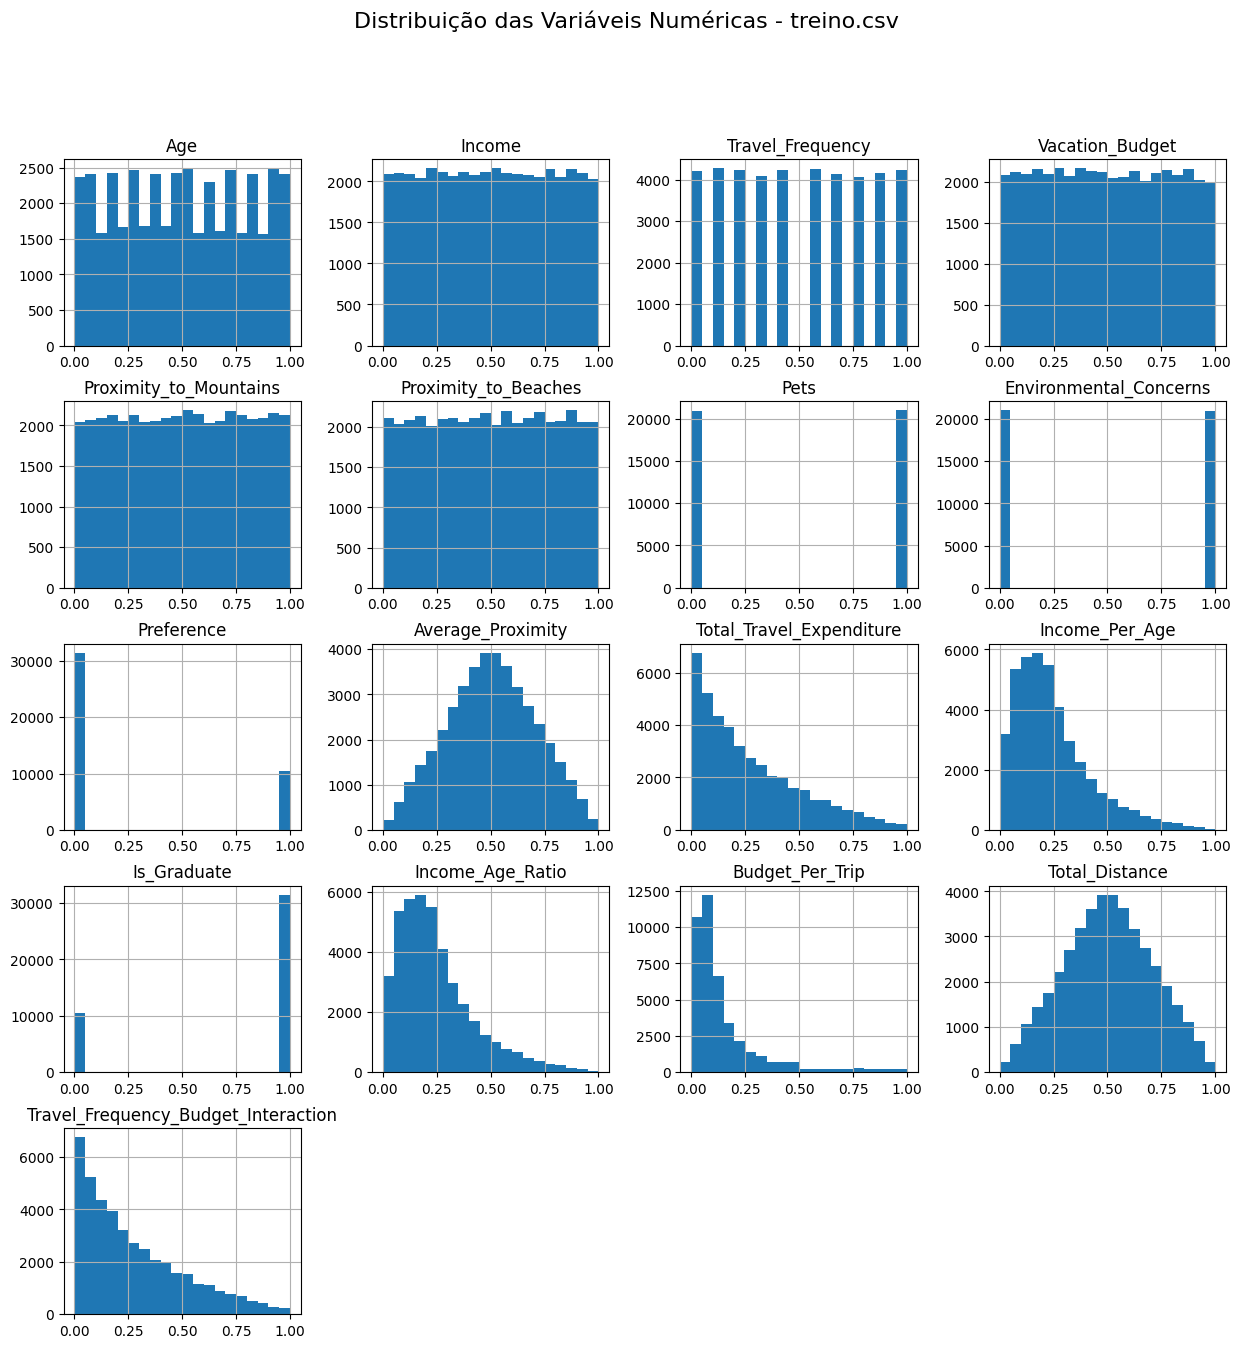

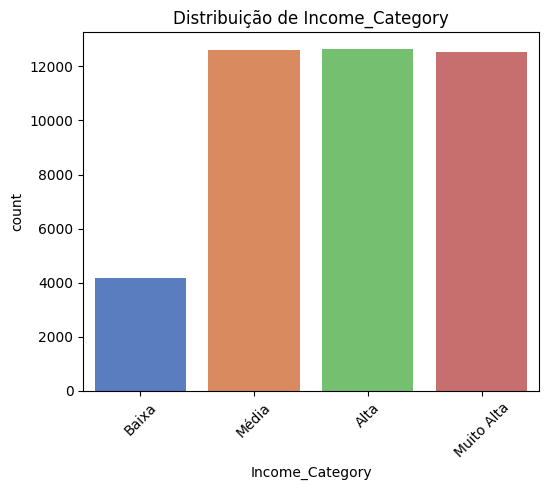

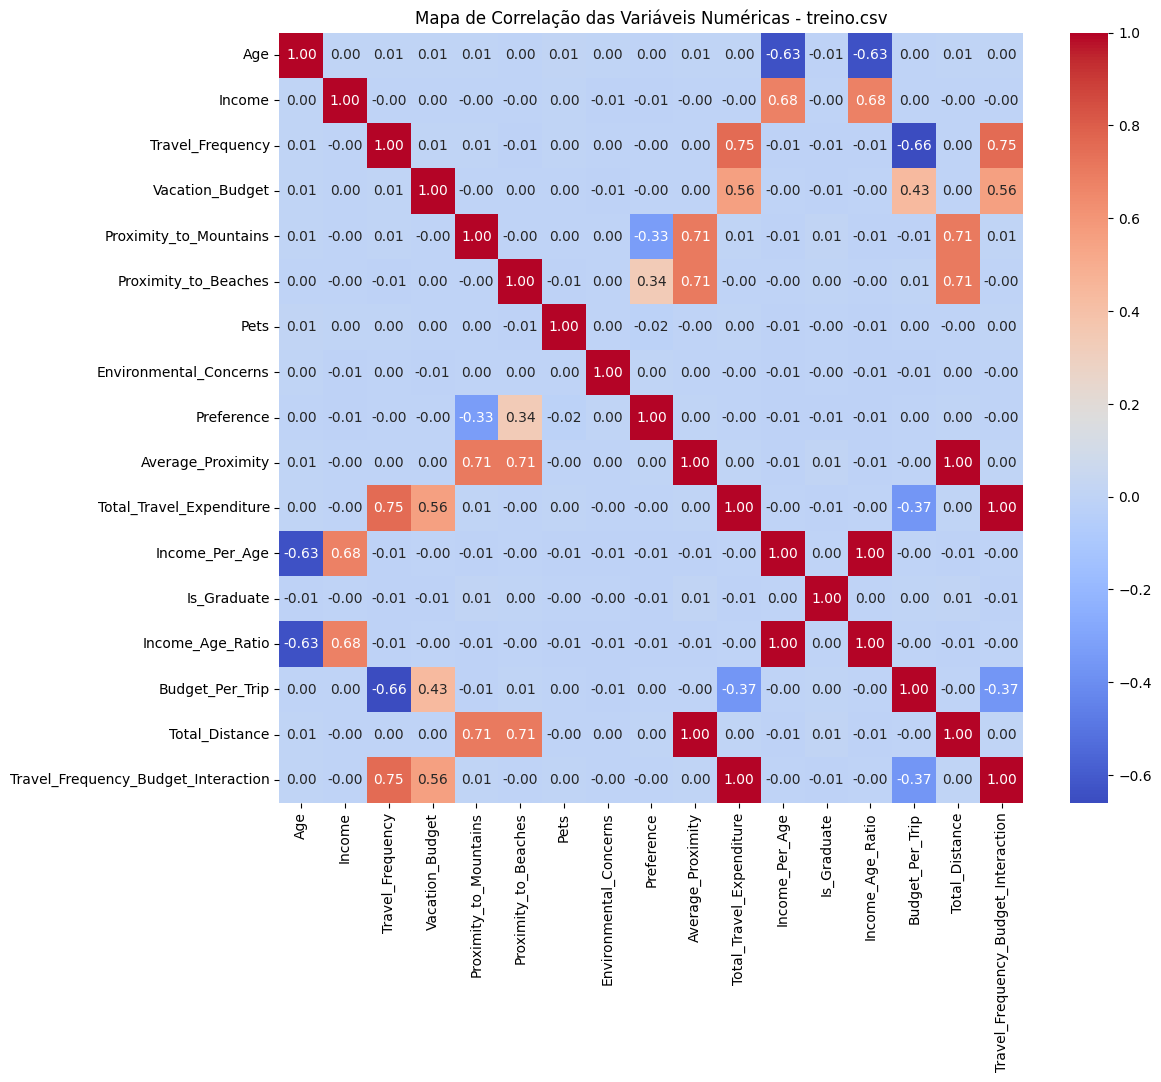

In [169]:
# Análise gráfca do treino
analise_grafica(data_train, "treino.csv")

In [170]:
# Estatísticas sobre as variáveis numéricas de teste
data_test.describe()

,Age,Income,Travel_Frequency,Vacation_Budget,Proximity_to_Mountains,Proximity_to_Beaches,Pets,Environmental_Concerns,Preference,Average_Proximity,Total_Travel_Expenditure,Income_Per_Age,Is_Graduate,Income_Age_Ratio,Budget_Per_Trip,Total_Distance,Travel_Frequency_Budget_Interaction
count,10489.000000,10489.000000,10489.000000,10489.000000,10489.000000,10489.000000,10489.000000,10489.000000,10489.000000,10489.000000,10489.000000,10489.000000,10489.000000,10489.000000,10489.000000,10489.000000,10489.000000
mean,0.501868,0.502369,0.500238,0.501337,0.497465,0.502284,0.502622,0.495185,0.251692,0.501552,0.275496,0.246546,0.749452,0.246546,0.153538,0.501552,0.275496
std,0.293996,0.290104,0.318652,0.288458,0.289686,0.288983,0.500017,0.500001,0.434006,0.206403,0.233143,0.177474,0.433349,0.177474,0.181733,0.206403,0.233143
min,0.000000,-0.000020,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006711,0.000000,0.001675,0.000000,0.001675,0.000040,0.006711,0.000000
25%,0.254902,0.251500,0.222222,0.253167,0.244147,0.257525,0.000000,0.000000,0.000000,0.354027,0.087057,0.116666,0.000000,0.116666,0.048852,0.354027,0.087057
50%,0.490196,0.507880,0.555556,0.501667,0.498328,0.501672,1.000000,0.000000,0.000000,0.501678,0.214664,0.208929,1.000000,0.208929,0.090799,0.501678,0.214664
75%,0.764706,0.754340,0.777778,0.751500,0.749164,0.755853,1.000000,1.000000,1.000000,0.649329,0.417500,0.328243,1.000000,0.328243,0.174520,0.649329,0.417500
max,1.000000,0.999960,1.000000,0.999778,1.000000,1.000000,1.000000,1.000000,1.000000,0.996644,0.998599,0.998053,1.000000,0.998053,1.000607,0.996644,0.998599


Análise Gráfica para teste.csv


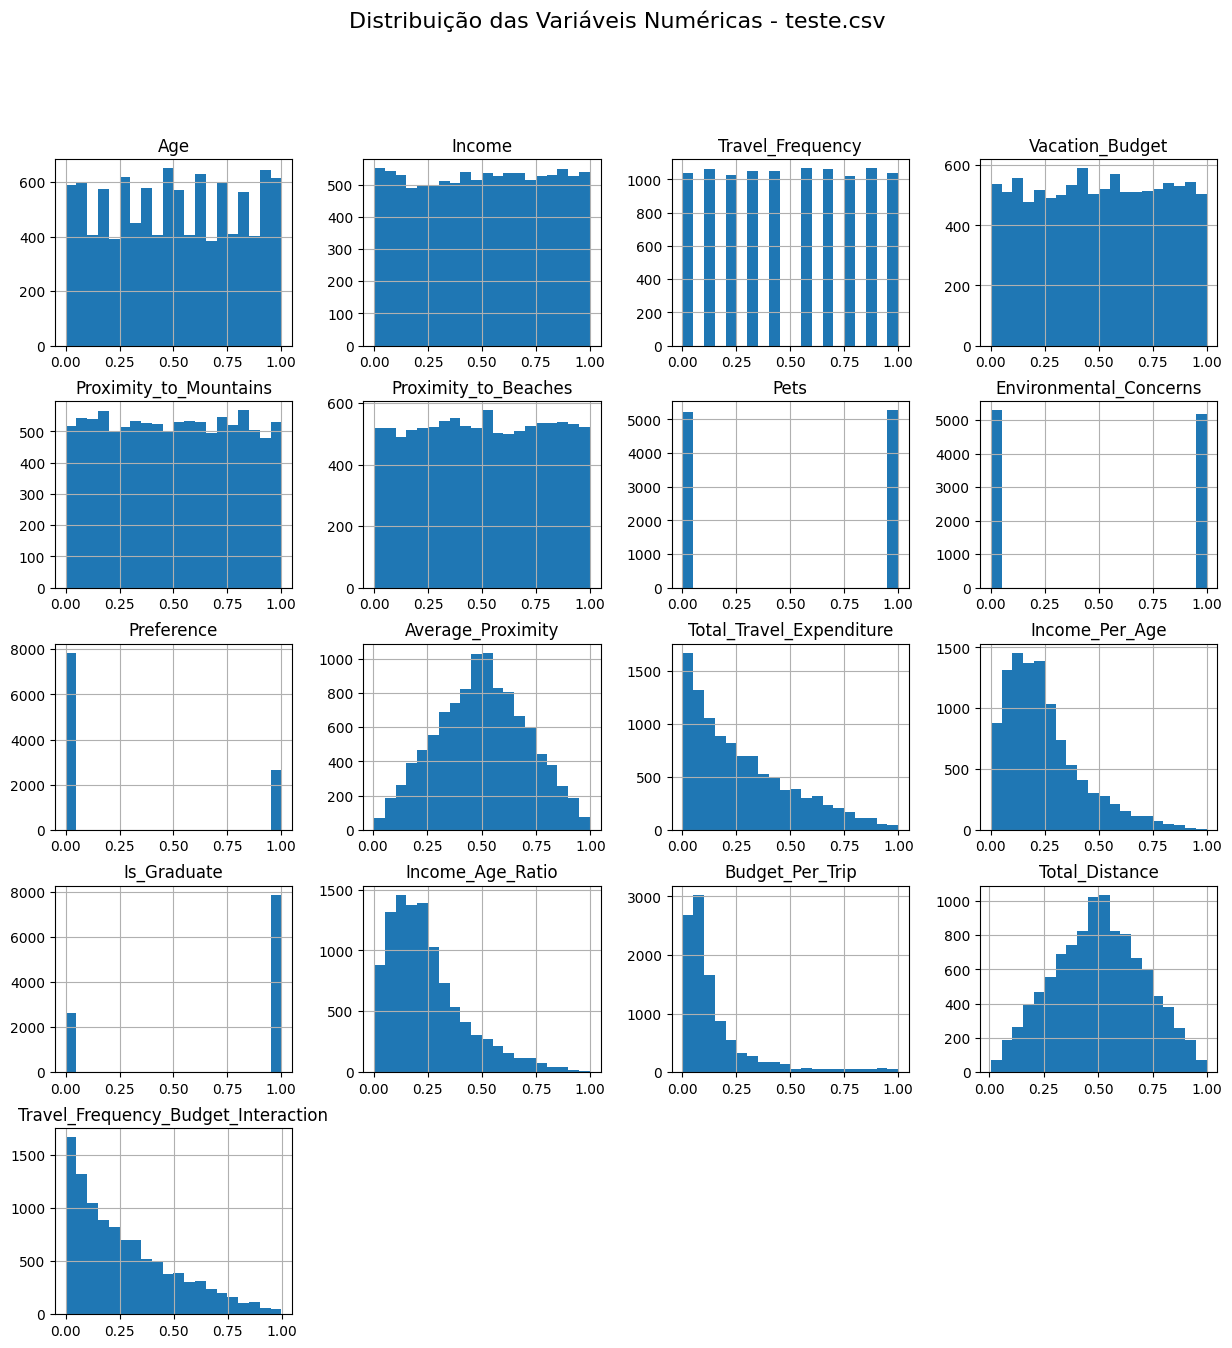

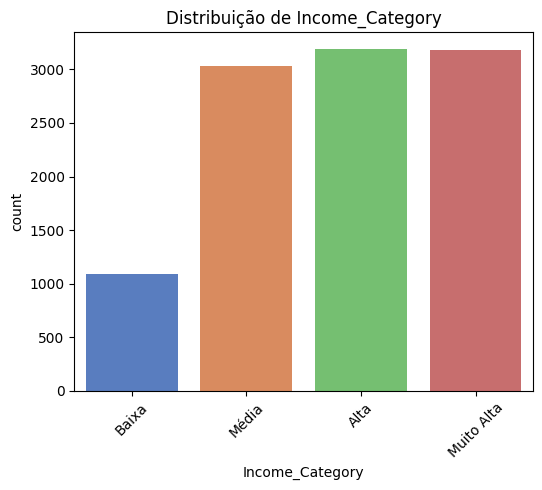

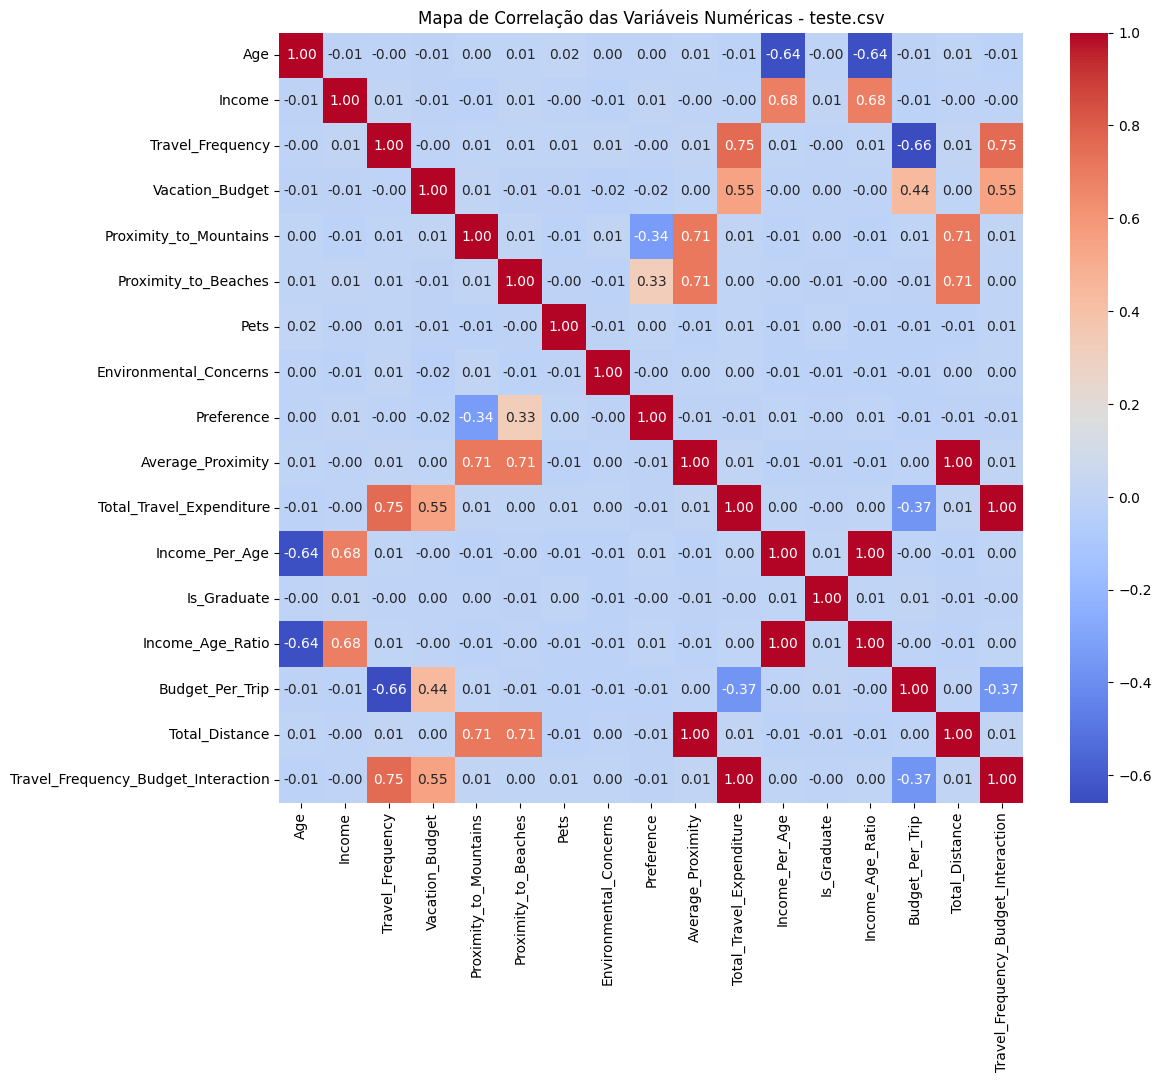

In [171]:
# Análise gráfca do teste
analise_grafica(data_test, "teste.csv")

In [172]:
# Lista de variáveis categóricas
colunas_cat = data_train.select_dtypes(include=['object']).columns.tolist()

# Estatísticas sobre as variáveis categóricas
for coluna in colunas_cat:
    print(f'### Coluna <{coluna}> ###')
    print(data_train[coluna].value_counts())
    print('-' * 40)

In [173]:
# Lista de variáveis categóricas
colunas_cat = data_test.select_dtypes(include=['object']).columns.tolist()

# Estatísticas sobre as variáveis categóricas
for coluna in colunas_cat:
    print(f'### Coluna <{coluna}> ###')
    print(data_test[coluna].value_counts())
    print('-' * 40)

In [174]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41955 entries, 0 to 41954
Data columns (total 31 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   Age                                  41955 non-null  float64 
 1   Income                               41955 non-null  float64 
 2   Travel_Frequency                     41955 non-null  float64 
 3   Vacation_Budget                      41955 non-null  float64 
 4   Proximity_to_Mountains               41955 non-null  float64 
 5   Proximity_to_Beaches                 41955 non-null  float64 
 6   Pets                                 41955 non-null  float64 
 7   Environmental_Concerns               41955 non-null  float64 
 8   Preference                           41955 non-null  float64 
 9   Average_Proximity                    41955 non-null  float64 
 10  Total_Travel_Expenditure             41955 non-null  float64 
 11  Income_Per_Age 

In [175]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10489 entries, 0 to 10488
Data columns (total 31 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   Age                                  10489 non-null  float64 
 1   Income                               10489 non-null  float64 
 2   Travel_Frequency                     10489 non-null  float64 
 3   Vacation_Budget                      10489 non-null  float64 
 4   Proximity_to_Mountains               10489 non-null  float64 
 5   Proximity_to_Beaches                 10489 non-null  float64 
 6   Pets                                 10489 non-null  float64 
 7   Environmental_Concerns               10489 non-null  float64 
 8   Preference                           10489 non-null  float64 
 9   Average_Proximity                    10489 non-null  float64 
 10  Total_Travel_Expenditure             10489 non-null  float64 
 11  Income_Per_Age 

In [176]:
# Verificando dados nulos do treino
print('Colunas com dados nulos:')
display(data_train.isnull().sum()[data_train.isnull().sum() > 0])

Colunas com dados nulos:


Series([], dtype: int64)

In [177]:
# Verificando dados nulos do teste
print('Colunas com dados nulos:')
display(data_test.isnull().sum()[data_test.isnull().sum() > 0])

Colunas com dados nulos:


Series([], dtype: int64)

In [178]:
# Definir a conversão para variáveis categóricas ordinais
conversao_variaveis = {
    'Gender': {
        'non-binary': 0,
        'female': 1,
        'male': 2
    },
    'Education_Level': {
        'high school': 1,
        'bachelor': 2,
        'master': 3,
        'doctorate': 4
    },
    'Preferred_Activities': {
        'hiking': 1,
        'skiing': 2,
        'swimming': 3,
        'sunbathing': 4
    },
    'Location': {
        'rural': 1,
        'suburban': 2,
        'urban': 3
    },
    'Favorite_Season': {
        'spring': 1,
        'fall': 2,
        'winter': 3,
        'summer': 4
    },
    'Pets': {
        0: 'No',  
        1: 'Yes'  
    },
    'Environmental_Concerns': {
        0: 'No',  
        1: 'Yes'  
    }
}

# Aplicar a conversão
data_train.replace(conversao_variaveis, inplace=True)
data_test.replace(conversao_variaveis, inplace=True)

# Visualizar uma amostra para confirmar a conversão
data_train.sample(5)
data_test.sample(5)


,Age,Income,Travel_Frequency,Vacation_Budget,Proximity_to_Mountains,Proximity_to_Beaches,Pets,Environmental_Concerns,Preference,Average_Proximity,...,Education_Level_high school,Education_Level_master,Preferred_Activities_skiing,Preferred_Activities_sunbathing,Preferred_Activities_swimming,Location_suburban,Location_urban,Favorite_Season_spring,Favorite_Season_summer,Favorite_Season_winter
9939,0.784314,0.489410,0.888889,0.009558,0.705686,0.030100,Yes,Yes,0.0,0.369128,...,True,False,True,False,False,False,True,False,False,False
2293,0.274510,0.245750,0.666667,0.919315,0.050167,0.153846,No,Yes,1.0,0.102349,...,False,False,True,False,False,False,False,False,False,False
9301,0.862745,0.018021,0.888889,0.721271,0.551839,0.551839,No,No,0.0,0.553691,...,False,True,False,False,False,False,False,False,True,False
633,0.843137,0.487870,1.000000,0.410980,0.280936,0.214047,Yes,Yes,0.0,0.248322,...,False,True,False,False,True,False,True,False,False,False
2379,0.470588,0.288692,0.111111,0.210491,0.107023,0.247492,No,Yes,1.0,0.177852,...,False,False,True,False,False,True,False,False,False,False


In [179]:
# Listar as variáveis categóricas (excluindo a variável alvo, se for categórica)
cols_cat_train = data_train.select_dtypes(include='object').columns.tolist()
cols_cat_test = data_train.select_dtypes(include='object').columns.tolist()

# Aplicar OneHotEncoding nas variáveis categóricas de treino e teste
data_train = pd.get_dummies(data_train, columns=cols_cat_train, drop_first=True)
data_test = pd.get_dummies(data_test, columns=cols_cat_test, drop_first=True)

# Garantir que as colunas nos conjuntos de treino e teste sejam as mesmas
# Isso é útil caso algumas categorias estejam ausentes em um dos conjuntos
data_train, data_test = data_train.align(data_test, join='left', axis=1, fill_value=0)

# Exibir uma amostra dos dados para verificar o resultado
print("Amostra dos dados de treino com OneHotEncoding:")
display(data_train.head())

print("Amostra dos dados de teste com OneHotEncoding:")
display(data_test.head())

Amostra dos dados de treino com OneHotEncoding:


,Age,Income,Travel_Frequency,Vacation_Budget,Proximity_to_Mountains,Proximity_to_Beaches,Preference,Average_Proximity,Total_Travel_Expenditure,Income_Per_Age,...,Preferred_Activities_skiing,Preferred_Activities_sunbathing,Preferred_Activities_swimming,Location_suburban,Location_urban,Favorite_Season_spring,Favorite_Season_summer,Favorite_Season_winter,Pets_Yes,Environmental_Concerns_Yes
0,0.627451,0.180887,0.333333,0.179595,0.137124,0.284281,1.0,0.211409,0.087235,0.074036,...,False,False,False,False,False,True,False,False,False,False
1,0.568627,0.302722,0.666667,0.401423,0.799331,0.729097,0.0,0.766779,0.307590,0.122413,...,False,False,False,False,True,False,True,False,False,True
2,0.450980,0.234409,0.888889,0.411425,0.742475,0.578595,0.0,0.662752,0.418123,0.120830,...,False,True,False,False,False,False,False,True,True,False
3,1.000000,0.425827,1.000000,0.126250,0.468227,0.254181,0.0,0.362416,0.213685,0.096853,...,False,True,False,False,True,False,True,False,False,True
4,0.980392,0.358034,0.111111,0.934430,0.989967,0.672241,0.0,0.833893,0.104575,0.083283,...,False,True,False,True,False,False,False,True,True,True


Amostra dos dados de teste com OneHotEncoding:


,Age,Income,Travel_Frequency,Vacation_Budget,Proximity_to_Mountains,Proximity_to_Beaches,Preference,Average_Proximity,Total_Travel_Expenditure,Income_Per_Age,...,Preferred_Activities_skiing,Preferred_Activities_sunbathing,Preferred_Activities_swimming,Location_suburban,Location_urban,Favorite_Season_spring,Favorite_Season_summer,Favorite_Season_winter,Pets_Yes,Environmental_Concerns_Yes
0,0.254902,0.251770,0.333333,0.102023,0.578595,0.515050,0.0,0.548658,0.063959,0.183344,...,False,True,False,True,False,False,True,False,True,False
1,0.647059,0.274401,0.555556,0.056902,0.026756,0.966555,1.0,0.498322,0.084034,0.100503,...,False,False,False,True,False,False,True,False,False,True
2,0.156863,0.728939,0.000000,0.067571,0.959866,0.678930,0.0,0.822148,0.000000,0.515784,...,False,True,False,False,False,False,False,True,True,False
3,0.784314,0.842974,0.555556,0.365192,0.956522,0.280936,0.0,0.620805,0.238206,0.236906,...,True,False,False,False,True,False,True,False,True,False
4,0.745098,0.756620,0.222222,0.917315,1.000000,0.404682,0.0,0.704698,0.205727,0.222766,...,False,False,True,True,False,True,False,False,False,False


In [180]:
print("Valores nulos do treino")

# Imputando os valores nulos com a média para colunas numéricas
numeric_cols = data_train.select_dtypes(include=['int64', 'float64']).columns
data_train[numeric_cols] = data_train[numeric_cols].fillna(data_train[numeric_cols].mean())

# Verifica valores nulos novamente
print(data_train.isnull().sum())

Valores nulos do treino
Age                                    0
Income                                 0
Travel_Frequency                       0
Vacation_Budget                        0
Proximity_to_Mountains                 0
Proximity_to_Beaches                   0
Preference                             0
Average_Proximity                      0
Total_Travel_Expenditure               0
Income_Per_Age                         0
Is_Graduate                            0
Income_Age_Ratio                       0
Budget_Per_Trip                        0
Total_Distance                         0
Travel_Frequency_Budget_Interaction    0
Income_Category                        0
Gender_male                            0
Gender_non-binary                      0
Education_Level_doctorate              0
Education_Level_high school            0
Education_Level_master                 0
Preferred_Activities_skiing            0
Preferred_Activities_sunbathing        0
Preferred_Activities_swimming    

In [181]:
print("Valores nulos do teste")

# Imputando os valores nulos com a média para colunas numéricas
numeric_cols = data_test.select_dtypes(include=['int64', 'float64']).columns
data_test[numeric_cols] = data_test[numeric_cols].fillna(data_test[numeric_cols].mean())

# Verifica valores nulos novamente
data_test.isnull().sum()

Valores nulos do teste


Age                                    0
Income                                 0
Travel_Frequency                       0
Vacation_Budget                        0
Proximity_to_Mountains                 0
Proximity_to_Beaches                   0
Preference                             0
Average_Proximity                      0
Total_Travel_Expenditure               0
Income_Per_Age                         0
Is_Graduate                            0
Income_Age_Ratio                       0
Budget_Per_Trip                        0
Total_Distance                         0
Travel_Frequency_Budget_Interaction    0
Income_Category                        0
Gender_male                            0
Gender_non-binary                      0
Education_Level_doctorate              0
Education_Level_high school            0
Education_Level_master                 0
Preferred_Activities_skiing            0
Preferred_Activities_sunbathing        0
Preferred_Activities_swimming          0
Location_suburba

In [182]:
# Separar as variáveis independentes (X) e dependente (y) nos conjuntos de treino e teste
X = data_train.drop(columns=['Preference'])
y = data_train['Preference']

# Dividir os dados em treino e teste com stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# Verificar as proporções de classes no conjunto de treino
print("### Proporção de Classes em Treino ###")
print(f"Porcentagem de entradas Classe 0: {y_train.value_counts(normalize=True).values[0] * 100:.2f}%")
print(f"Porcentagem de entradas Classe 1: {y_train.value_counts(normalize=True).values[1] * 100:.2f}%")
print()

# Verificar as proporções de classes no conjunto de teste
print("### Proporção de Classes em Teste ###")
print(f"Porcentagem de entradas Classe 0: {y_test.value_counts(normalize=True).values[0] * 100:.2f}%")
print(f"Porcentagem de entradas Classe 1: {y_test.value_counts(normalize=True).values[1] * 100:.2f}%")

### Proporção de Classes em Treino ###
Porcentagem de entradas Classe 0: 74.96%
Porcentagem de entradas Classe 1: 25.04%

### Proporção de Classes em Teste ###
Porcentagem de entradas Classe 0: 74.95%
Porcentagem de entradas Classe 1: 25.05%


In [183]:
# Análise e Tratamento de Valores Faltantes
def preprocess_data(data):
    imputer = SimpleImputer(strategy='most_frequent')
    data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
    
    # Codificação de variáveis categóricas
    data = pd.get_dummies(data, columns=['Gender', 'Education_Level', 'Preferred_Activities', 'Location', 'Favorite_Season'], drop_first=True)
    
    # Normalização das features numéricas
    scaler = StandardScaler()
    numeric_features = ['Age', 'Income', 'Travel_Frequency', 'Vacation_Budget', 'Proximity_to_Mountains', 'Proximity_to_Beaches']
    data[numeric_features] = scaler.fit_transform(data[numeric_features])
    
    return data

In [184]:
# Pré-processar dados de treino e teste

# Certificar que todas as colunas são numéricas antes do pré-processamento
data_train = data_train.apply(pd.to_numeric, errors='coerce')
data_test = data_test.apply(pd.to_numeric, errors='coerce')

# Selecionar apenas colunas numéricas
data_train = data_train.select_dtypes(include=[np.number])
data_test = data_test.select_dtypes(include=[np.number])

# Preencher valores NaN resultantes da conversão
data_train = data_train.fillna(0)
data_test = data_test.fillna(0)

# Separando features e target
X_train = data_train.drop(columns=['Preference'])
y_train = data_train['Preference']
X_test = data_test.drop(columns=['Preference'])
y_test = data_test['Preference']

# Verificar se todas as colunas são numéricas após a transformação
if not all(data_train.dtypes.apply(lambda x: np.issubdtype(x, np.number))):
    raise ValueError("Existem colunas não numéricas em data_train após a transformação.")

if not all(data_test.dtypes.apply(lambda x: np.issubdtype(x, np.number))):
    raise ValueError("Existem colunas não numéricas em data_test após a transformação.")

print("Todas as colunas são numéricas após a transformação.")

# Seleção de features
selector = SelectKBest(f_classif, k=10)
X_train = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)

# Obter os nomes das colunas selecionadas
selected_columns = data_train.drop(columns=['Preference']).columns[selector.get_support()]

# Transformar X_train e X_test de volta em DataFrames
X_train = pd.DataFrame(X_train, columns=selected_columns)
X_test = pd.DataFrame(X_test, columns=selected_columns)

Todas as colunas são numéricas após a transformação.


C:\Users\LIS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [14] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\LIS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [185]:
# Identificando colunas numéricas e categóricas
numeric_cols = data_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = data_train.select_dtypes(include=['object']).columns.tolist()

# Inicializando o scaler Min-Max
scaler = MinMaxScaler()

# Normalizando os dados numéricos de treino para o intervalo [0, 1]
data_train[numeric_cols] = scaler.fit_transform(data_train[numeric_cols])

# Normalizando os dados numéricos de teste (usando os parâmetros do treino)
data_test[numeric_cols] = scaler.transform(data_test[numeric_cols])

# Aplicar One-Hot Encoding nas variáveis categóricas de treino e teste
data_train = pd.get_dummies(data_train, columns=categorical_cols, drop_first=True)
data_test = pd.get_dummies(data_test, columns=categorical_cols, drop_first=True)

# Garantir que

In [186]:
# Identificando colunas numéricas e categóricas
numeric_cols = data_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = data_train.select_dtypes(include=['object']).columns.tolist()

# Inicializando o scaler Min-Max
scaler = MinMaxScaler()

# Normalizando os dados numéricos de treino para o intervalo [0, 1]
data_train[numeric_cols] = scaler.fit_transform(data_train[numeric_cols])

# Normalizando os dados numéricos de teste (usando os parâmetros do treino)
data_test[numeric_cols] = scaler.transform(data_test[numeric_cols])

# Aplicar One-Hot Encoding nas variáveis categóricas de treino e teste
data_train = pd.get_dummies(data_train, columns=categorical_cols, drop_first=True)
data_test = pd.get_dummies(data_test, columns=categorical_cols, drop_first=True)

# Garantir que as colunas nos conjuntos de

In [187]:
# Identificando colunas numéricas e categóricas
numeric_cols = data_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = data_train.select_dtypes(include=['object']).columns.tolist()

# Inicializando o scaler Min-Max
scaler = MinMaxScaler()

# Normalizando os dados numéricos de treino para o intervalo [0, 1]
data_train[numeric_cols] = scaler.fit_transform(data_train[numeric_cols])

# Normalizando os dados numéricos de teste (usando os parâmetros do treino)
data_test[numeric_cols] = scaler.transform(data_test[numeric_cols])

# Aplicar One-Hot Encoding nas variáveis categóricas de treino e teste
data_train = pd.get_dummies(data_train, columns=categorical_cols, drop_first=True)
data_test = pd.get_dummies(data_test, columns=categorical_cols, drop_first=True)

# Garantir que as colunas nos conjuntos de treino e teste sejam as

In [188]:
def performance_modelo_classificacao(model, X_train, X_test, y_train, y_test, flag=True):
    # Lista para armazenar os resultados de Treino e Teste
    score_list = []

    # Predição em Treino e Teste
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    # Acurácia do modelo
    train_acc = accuracy_score(y_train, pred_train)
    test_acc = accuracy_score(y_test, pred_test)

    # Recall do modelo
    train_recall = recall_score(y_train, pred_train)
    test_recall = recall_score(y_test, pred_test)

    # Precisão do modelo
    train_prec = precision_score(y_train, pred_train)
    test_prec = precision_score(y_test, pred_test)

    # F1-Score do modelo
    train_f1 = f1_score(y_train, pred_train)
    test_f1 = f1_score(y_test, pred_test)

    # Popula a lista
    score_list.extend((train_acc, test_acc, train_recall, test_recall, train_prec, test_prec, train_f1, test_f1))

    # Imprime os resultados se flag=True
    if flag:
        print(f'Acurácia na base de Treino: {train_acc:.4f}')
        print(f'Acurácia na base de Teste: {test_acc:.4f}')
        print(f'\nRecall na base de Treino: {train_recall:.4f}')
        print(f'Recall na base de Teste: {test_recall:.4f}')
        print(f'\nPrecisão na base de Treino: {train_prec:.4f}')
        print(f'Precisão na base de Teste: {test_prec:.4f}')
        print(f'\nF1-Score na base de Treino: {train_f1:.4f}')
        print(f'F1-Score na base de Teste: {test_f1:.4f}')

    # Retorna a lista de valores de métricas para Treino e Teste
    return score_list

In [189]:
# Função para exibir a matriz de confusão
def matriz_confusao(model, X, y_actual, labels=(1, 0)):
    y_predict = model.predict(X)
    cm = confusion_matrix(y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index=['Real - Não (0)', 'Real - Sim (1)'],
                         columns=['Previsto - Não (0)', 'Previsto - Sim (1)'])
    group_counts = [f'{value:.0f}' for value in cm.flatten()]
    group_percentages = [f'{value:.2f}%' for value in (cm.flatten() / np.sum(cm)) * 100]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=labels, fmt='', cmap='Blues')
    plt.xlabel('Classe Prevista', fontweight='bold')
    plt.ylabel('Classe Real', fontweight='bold')
    plt.show()

In [190]:
# Instanciando o modelo de Árvore de Decisão
arvore_d = DecisionTreeClassifier(criterion="entropy", random_state=1)

# Treinando o modelo
arvore_d.fit(X_train, y_train)

# Avaliando o modelo no conjunto de treino e teste
print("### Avaliação do Modelo de Árvore de Decisão ###")
arvore_d_scores = performance_modelo_classificacao(arvore_d, X_train, X_test, y_train, y_test)

### Avaliação do Modelo de Árvore de Decisão ###
Acurácia na base de Treino: 1.0000
Acurácia na base de Teste: 0.7463

Recall na base de Treino: 1.0000
Recall na base de Teste: 0.4928

Precisão na base de Treino: 1.0000
Precisão na base de Teste: 0.4960

F1-Score na base de Treino: 1.0000
F1-Score na base de Teste: 0.4944


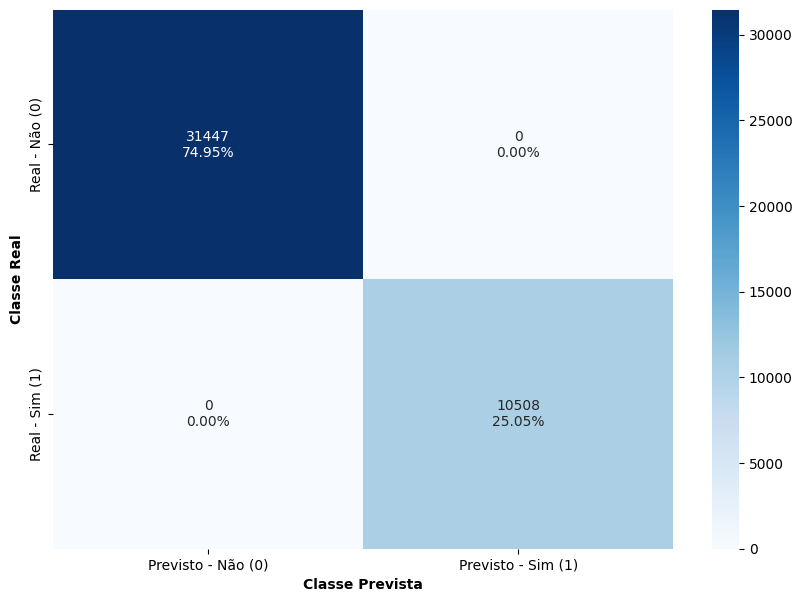

In [191]:
# Matriz de Confusão de treino
matriz_confusao(arvore_d, X_train, y_train)

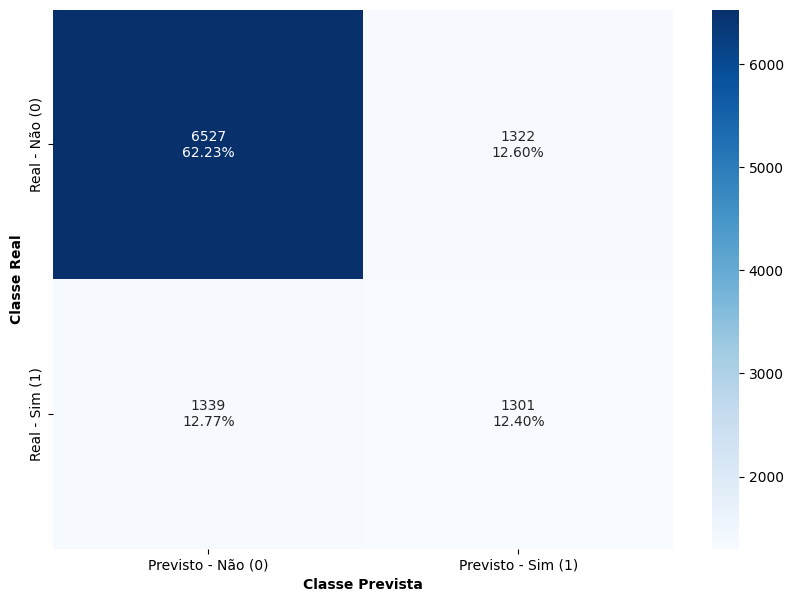

In [192]:
# Matriz de Confusão de teste
matriz_confusao(arvore_d, X_test, y_test)

In [ ]:
# Plot da árvore
feature_names = list(X_train.columns)

plt.figure(figsize=(20, 30))
tree.plot_tree(arvore_d, feature_names=feature_names, filled=True,
            fontsize=9, node_ids=True, class_names=True);

In [ ]:
# Instanciando o modelo de Árvore de Decisão com Poda
arvore_d1 = DecisionTreeClassifier(criterion="entropy", random_state=1, max_depth=3)

# Treinando o modelo
arvore_d1.fit(X_train, y_train)

# Avaliando o modelo no conjunto de treino e teste
print("### Avaliação do Modelo de Árvore de Decisão ###")
arvore_d1_scores = performance_modelo_classificacao(arvore_d1, X_train, X_test, y_train, y_test)

### Avaliação do Modelo de Árvore de Decisão ###
Acurácia na base de Treino: 0.8759
Acurácia na base de Teste: 0.8751

Recall na base de Treino: 0.7566
Recall na base de Teste: 0.7553

Precisão na base de Treino: 0.7501
Precisão na base de Teste: 0.7502

F1-Score na base de Treino: 0.7533
F1-Score na base de Teste: 0.7527


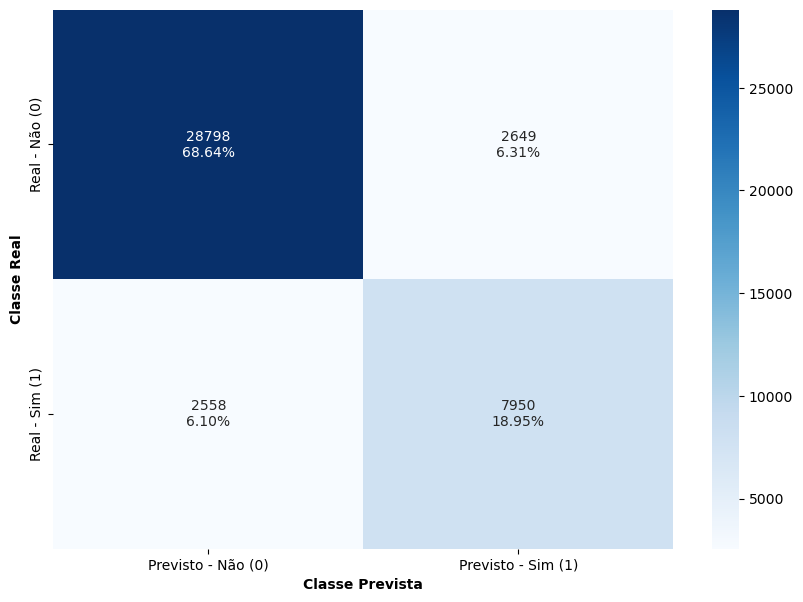

In [ ]:
# Matriz de Confusão de treino
matriz_confusao(arvore_d1, X_train, y_train)

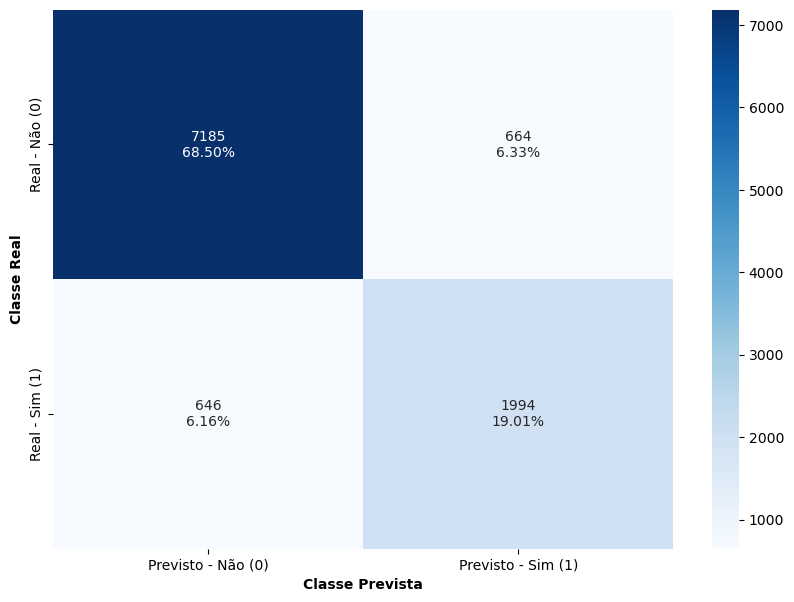

In [ ]:
# Matriz de Confusão de teste
matriz_confusao(arvore_d1, X_test, y_test)

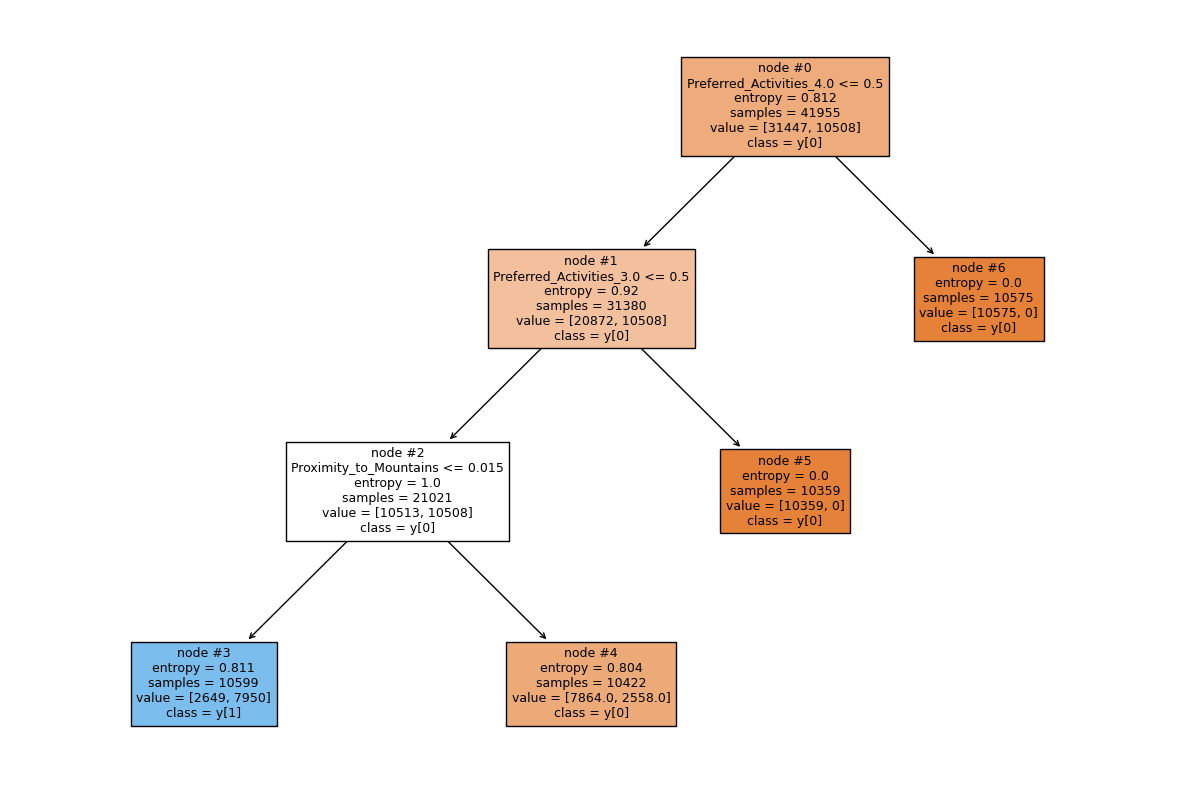

In [ ]:
feature_names = list(X_train.columns)

plt.figure(figsize=(15, 10))
tree.plot_tree(arvore_d1, feature_names=feature_names, filled=True,
            fontsize=9, node_ids=True, class_names=True);

Mean Squared Error: 0.17
R² Score: 0.12


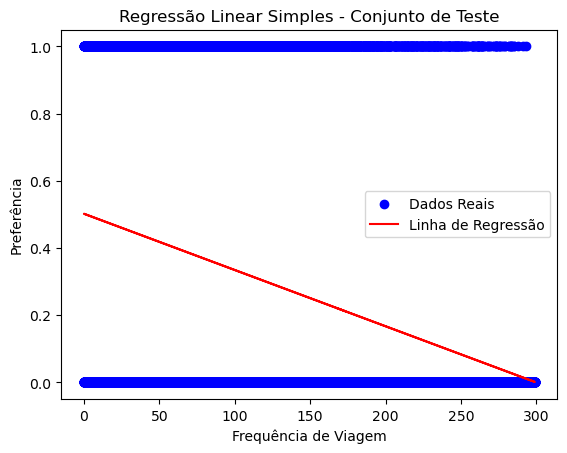

In [ ]:
# Carregando os dados
df_train = pd.read_csv('treino.csv', sep=',', encoding='iso-8859-1')
df_test = pd.read_csv('teste.csv', sep=',', encoding='iso-8859-1')

## Separando as variáveis independentes (X) e dependente (y) para o conjunto de treino
X_train = df_train[['Proximity_to_Mountains']]
y_train = df_train['Preference']   # Variável alvo

# Instanciando o modelo de Regressão Linear
modelo_linear = LinearRegression()

# Treinando o modelo com os dados de treino
modelo_linear.fit(X_train, y_train)

# Separando as variáveis independentes (X) e dependente (y) para o conjunto de teste
X_test = df_test[['Proximity_to_Mountains']]
y_test = df_test['Preference']   # Variável alvo

# Fazendo previsões com os dados de teste
y_pred = modelo_linear.predict(X_test)

# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R² Score: {r2:.2f}')

# Visualizando os resultados
plt.scatter(X_test, y_test, color='blue', label='Dados Reais')
plt.plot(X_test, y_pred, color='red', label='Linha de Regressão')
plt.title('Regressão Linear Simples - Conjunto de Teste')
plt.xlabel('Frequência de Viagem')
plt.ylabel('Preferência')
plt.legend()
plt.show()

Accuracy: 0.69
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.83      0.80      7849
           1       0.36      0.29      0.32      2640

    accuracy                           0.69     10489
   macro avg       0.57      0.56      0.56     10489
weighted avg       0.67      0.69      0.68     10489

Confusion Matrix:
[[6519 1330]
 [1885  755]]


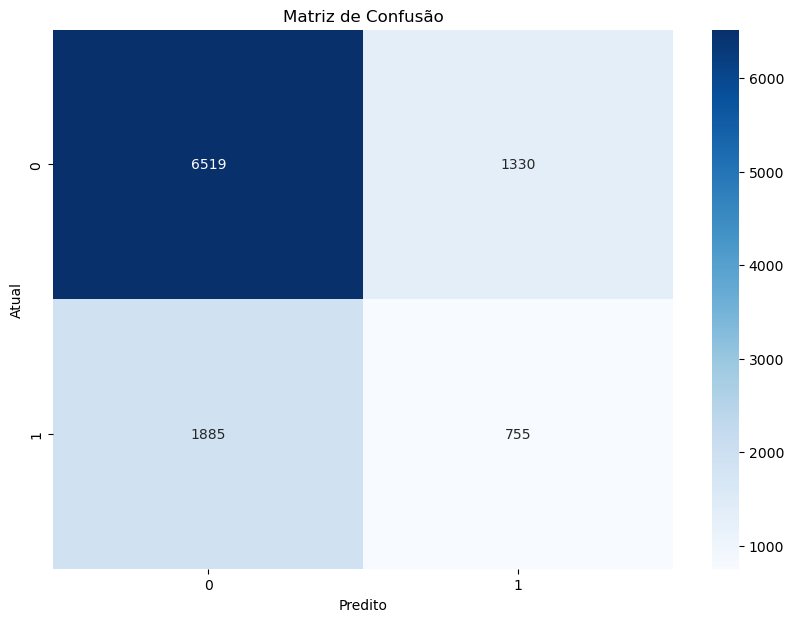

In [ ]:
# Carregando os dados
df_train = pd.read_csv('treino.csv', sep=',', encoding='iso-8859-1')
df_test = pd.read_csv('teste.csv', sep=',', encoding='iso-8859-1')

# Separando as variáveis independentes (X) e dependente (y) para o conjunto de treino
X_train = df_train[['Proximity_to_Mountains']]
y_train = df_train['Preference']   # Variável alvo

# Separando as variáveis independentes (X) e dependente (y) para o conjunto de teste
X_test = df_test[['Proximity_to_Mountains']]
y_test = df_test['Preference']   # Variável alvo

# Instanciando o modelo KNN
knn_model = KNeighborsClassifier(n_neighbors=3)  # Você pode ajustar o número de vizinhos (k)

# Treinando o modelo com os dados de treino
knn_model.fit(X_train, y_train)

# Fazendo previsões com os dados de teste
y_pred = knn_model.predict(X_test)

# Avaliando o modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('Classification Report:')
print(classification_report(y_test, y_pred))

print('Confusion Matrix:')
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# Visualizando a matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Atual')
plt.show()